# PROJECT AML : UrbanSound8k

## Some information about the dataset
This dataset is composed of 6.6GB of data, including 8732 sound files of around 4 seconds(but less or equal) and 1 CSV file giving info about files where to find them in the dataset,their original file, their location in the original files, and of course their classes in ID but also with the name associated to it, also if the sound to detect is in foreground or background.

There are ten classes of sound and the aim of this project is to develop a classifier for this sound.

The ten classes are : airconditioner, carhorn, childrenplaying, dogbark, drilling, engineidling, gunshot, jackhammer, siren, street_music.

## How I will do it ?
So the idea is to develop a classifier I decided to use features generating a 2D representation of the sound and applying CNN on the generated representation to classify the classes.

## Some informations before running
You have to clone this folder : https://drive.google.com/drive/folders/1MH2S699CGllBy_HJhG2MUJ07uiyectY8?usp=sharing, to your drive and adapt paths according to your folder hierarchy.

## Imports and define some paths





In [47]:
!pip install torchaudio
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## related to sound
import torchaudio
import torchaudio.transforms as T
import IPython.display as ipd

## Related to deeplearning
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

## Related to data connect
from google.colab import drive

In [48]:
PATH_TO_FOLDER ="/MyDrive/SoundClassif/"
CSV_FILENAME = "UrbanSound8K.csv"
MOUNTING_LOCATION = "/content/drive"

# DF VARS
FILENAME = "slice_file_name"
FID = "fsID"
START = "start"
END = "end"
SL = 	"salience"	
FOLD = "fold"
CLASSID = "classID"
CLASS = "class"

## Define some processing and visualization functions


In [49]:
def plot_spectrogram(waveform, title=None, ylabel='freq_bin', aspect='auto', axs = None):
  if axs is None :
    fig, axs = plt.subplots(1, 1)
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)
  res = amp(np.abs(torch.stft(waveform,2048)))[0]
  y = torch.sum(res.permute(2,0,1),axis =0)
  im = axs.imshow(y)
  plt.title(title or 'Spectrogram (db)')

def plot_waveform(waveform, sample_rate, title="Waveform", axes = None):
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate
  waveform = waveform[0]
  if axes is None:
    figure, axes = plt.subplots(1, 1)
  plt.plot(time_axis, waveform, linewidth=1)
  plt.title(title)

def load_sound_by_index(file_index, df):
  sound_picked_fn = df[FILENAME][file_index]
  waveform, sr = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(df[FOLD][file_index])+os.path.sep+sound_picked_fn) # load audio
  audio_mono = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono
  return audio_mono

## Import data

In [50]:
drive.mount(MOUNTING_LOCATION)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
df = pd.read_csv(MOUNTING_LOCATION+PATH_TO_FOLDER+CSV_FILENAME)
#df = df.loc[df["fold"]==1].reset_index(drop=True)  ## Select only mounting folder 1 (used for fast test)
r,c = df.shape
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


##Exploratory data analysis

In [52]:
print(f"In this dataset there is {df.shape[0]} sounds")

In this dataset there is 8732 sounds


Text(0.5, 1.0, 'Classes histogram')

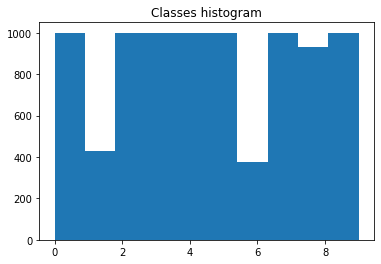

In [53]:
plt.hist(df[CLASSID].values, bins=10,range=(0,9))
plt.title('Classes histogram')

Text(0.5, 1.0, 'Salience (1: Foreground, 2: Background)')

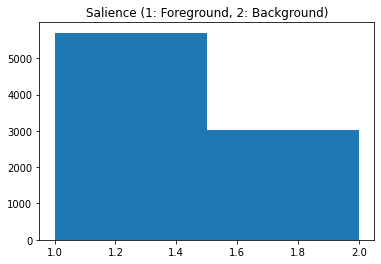

In [54]:
plt.hist(df[SL].values, bins=2,range=(1,2))
plt.title('Salience (1: Foreground, 2: Background)')

In [55]:
print(f"There is {len(np.unique(df[FID].values))} differents sources of sound in this dataset.")

There is 1297 differents sources of sound in this dataset.


### Sample pick

In [56]:
dfC1 = df[df[CLASSID]==1].reset_index(drop=True)
index = 20
sound_picked_fn = dfC1[FILENAME][index]
class_name1 = dfC1[CLASS][index]
waveform, sr1 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC1[FOLD][index])+os.path.sep+sound_picked_fn) # load audio
audio_mono1 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

dfC2 = df[df[CLASSID]==2].reset_index(drop=True)
sound_picked_fn = dfC2[FILENAME][0]
class_name2 = dfC2[CLASS][0]
waveform, sr2 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC2[FOLD][0])+os.path.sep+sound_picked_fn) # load audio
audio_mono2 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

dfC3 = df[df[CLASSID]==3].reset_index(drop=True)
sound_picked_fn = dfC3[FILENAME][10]
class_name3 = dfC3[CLASS][10]
waveform, sr3 = torchaudio.load(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+ str(dfC3[FOLD][10])+os.path.sep+sound_picked_fn) # load audio
audio_mono3 = torch.mean(waveform, dim=0, keepdim=True) # Convert sterio to mono

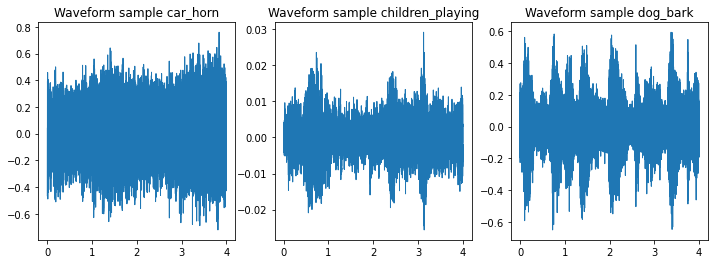

In [57]:
sfig, saxs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

plt.sca(saxs[0])
plot_waveform(audio_mono1.numpy(),sr1, title="Waveform sample "+str(class_name1),axes=saxs[0])

plt.sca(saxs[1])
plot_waveform(audio_mono2.numpy(),sr2, title="Waveform sample "+str(class_name2),axes=saxs[1])

plt.sca(saxs[2])
plot_waveform(audio_mono3.numpy(),sr3,title="Waveform sample "+str(class_name3),axes=saxs[2])

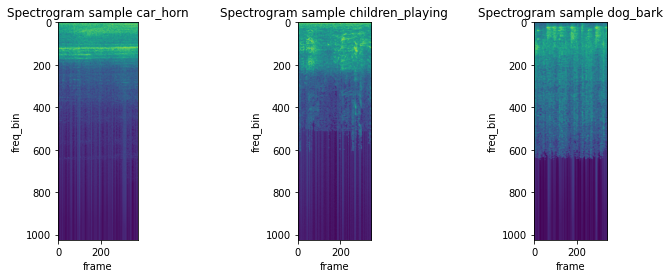

In [58]:
mfig, maxs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.sca(maxs[0])
plot_spectrogram(audio_mono1, title="Spectrogram sample "+class_name1,axs=maxs[0])

plt.sca(maxs[1])
plot_spectrogram(audio_mono2, title="Spectrogram sample "+class_name2,axs=maxs[1])

plt.sca(maxs[2])
plot_spectrogram(audio_mono3, title="Spectrogram sample "+class_name3,axs=maxs[2])

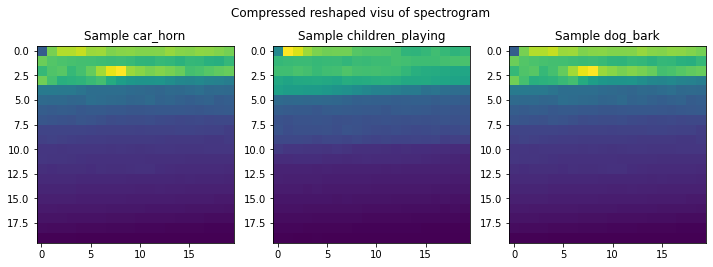

In [59]:
amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)
i1 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono1,799)[0])), axis=2).T, axis=0).reshape(20,20))
i2 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono2,799)[0])), axis=2).T, axis=0).reshape(20,20))
i3 = (torch.mean(torch.sum(amp(torch.abs(torch.stft(audio_mono3,799)[0])), axis=2).T, axis=0).reshape(20,20))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.sca(axs[0])
plt.imshow(i1)
plt.title("Sample "+class_name1)
plt.sca(axs[1])
plt.imshow(i2)
plt.title("Sample "+class_name2)
plt.sca(axs[2])
plt.imshow(i1)
plt.title("Sample "+class_name3)
#plt.tight_layout()
plt.suptitle('Compressed reshaped visu of spectrogram')
plt.show()

## Preprocessing


In [60]:
arrOfImages = []
amp = torchaudio.transforms.AmplitudeToDB('magnitude',top_db=80)

def specAndResize(i):
    return  (torch.mean(torch.sum(amp(torch.abs(torch.stft(load_sound_by_index(i, df),799)[0])), axis=2).T, axis=0).reshape(20,20))

for i in range(0, df.shape[0]):
  if (i%500 == 0):
    print("Pourcentage effectué : "+str(int((i/df.shape[0])*100)))
  arrOfImages.append(specAndResize(i))
  
arrOfImages = np.array([els.numpy() for els in arrOfImages])

Pourcentage effectué : 0
Pourcentage effectué : 5
Pourcentage effectué : 11
Pourcentage effectué : 17
Pourcentage effectué : 22
Pourcentage effectué : 28
Pourcentage effectué : 34
Pourcentage effectué : 40
Pourcentage effectué : 45
Pourcentage effectué : 51
Pourcentage effectué : 57
Pourcentage effectué : 62
Pourcentage effectué : 68
Pourcentage effectué : 74
Pourcentage effectué : 80
Pourcentage effectué : 85
Pourcentage effectué : 91
Pourcentage effectué : 97


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class SoundDataset(Dataset):
    def __init__(self, dataframe, arrayOfImages , transform=None):
        """
        Args:
            dataframe (Panda df): dataframe for sounds
            transform (callable, optional): Optional transform to be applied
                on a sample.
            images (numpy array 2D) : Array of images (compressed spectrograms)
        """
        self.sound_frame = dataframe
        self.transform = transform
        self.images = arrayOfImages

    def __len__(self):
        return len(self.sound_frame)

    def filename(self, idx):
      return os.path.join(MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+str(self.sound_frame[FOLD][idx])+os.path.sep,self.sound_frame[FILENAME][idx]) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        spec = self.images.squeeze()[idx]
        image=spec
        target = self.sound_frame[CLASSID][idx]

        if self.transform:
            image = self.transform(image)

        return image, target

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((20,20)), transforms.Normalize(np.mean(arrOfImages),np.std(arrOfImages))])

ds = SoundDataset(df,arrOfImages, transform=transform)
train_set, val_test_set = torch.utils.data.random_split(ds, [round(r*0.6), r-round(r*0.6)])
test_set, val_set = torch.utils.data.random_split(val_test_set, [int((r-round(r*0.6))*0.5),int((r-round(r*0.6))*0.5)+1])#+1
train_loader = DataLoader(train_set, batch_size=16,shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=16,shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=16,shuffle=True, num_workers=2)

cpu


In [62]:
class Mycnn(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        self.conv1 = nn.Conv2d(1,64,3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.conv5 = nn.Conv2d(64,128,3, padding=1)
        self.conv6 = nn.Conv2d(128,128,3, padding=1)
        self.fully_connected1 = nn.Linear(128*9,128)
        self.dropout = nn.Dropout(0.4)
        self.fully_connected3 = nn.Linear(128,10)
        self.batch_norm = nn.BatchNorm2d(128*8)
      
    def forward(self, x):
        # TODO
        x = self.pool2(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv5(x)))
        x = self.pool2(F.relu(self.conv6(x)))  
        x = self.pool2(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 128*9)
        x = F.relu(self.fully_connected1(x))
        x = self.dropout(x)
        x = self.fully_connected3(x)  
        x = F.log_softmax(x)      
        return x

criterion = nn.NLLLoss()
model = Mycnn().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 0.001, amsgrad=True)

epochs = 50
steps = 0
running_loss = 0
loss_tab = []
val_loss_tab = []
val_acc_tab = []
acc_tab = []
accuracy = 0
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
 
        res = model(inputs)
        loss = criterion(res, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()     
    
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
        valid_pred = top_class == labels.view(*top_class.shape)
        count = torch.mean((valid_pred).type(torch.FloatTensor))
        accuracy += count
    val_loss = 0
    val_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            res = model(inputs)
            valR_loss = criterion(res, labels)

            val_loss += valR_loss.item()
            top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
            valid_pred = top_class == labels.view(*top_class.shape)
            count = torch.mean((valid_pred).type(torch.FloatTensor))
            val_accuracy += count
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Val loss: {val_loss/len(val_loader):.3f}.. "
          f"Val accuracy: {val_accuracy/len(val_loader):.3f}")
    val_loss_tab.append(val_loss/len(val_loader))
    loss_tab.append(val_loss/len(train_loader))
    val_acc_tab.append(val_accuracy/len(val_loader))
    acc_tab.append(accuracy/len(train_loader))
    accuracy = 0
    running_loss = 0
    model.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/50.. Train loss: 2.046.. Val loss: 1.705.. Val accuracy: 0.377
Epoch 2/50.. Train loss: 1.662.. Val loss: 1.470.. Val accuracy: 0.476
Epoch 3/50.. Train loss: 1.390.. Val loss: 1.215.. Val accuracy: 0.561
Epoch 4/50.. Train loss: 1.185.. Val loss: 1.090.. Val accuracy: 0.629
Epoch 5/50.. Train loss: 1.025.. Val loss: 0.998.. Val accuracy: 0.667
Epoch 6/50.. Train loss: 0.869.. Val loss: 0.864.. Val accuracy: 0.721
Epoch 7/50.. Train loss: 0.740.. Val loss: 0.823.. Val accuracy: 0.725
Epoch 8/50.. Train loss: 0.654.. Val loss: 0.672.. Val accuracy: 0.770
Epoch 9/50.. Train loss: 0.570.. Val loss: 0.661.. Val accuracy: 0.783
Epoch 10/50.. Train loss: 0.494.. Val loss: 0.596.. Val accuracy: 0.802
Epoch 11/50.. Train loss: 0.424.. Val loss: 0.620.. Val accuracy: 0.809
Epoch 12/50.. Train loss: 0.388.. Val loss: 0.491.. Val accuracy: 0.848
Epoch 13/50.. Train loss: 0.338.. Val loss: 0.589.. Val accuracy: 0.812
Epoch 14/50.. Train loss: 0.301.. Val loss: 0.516.. Val accuracy: 0.851
E

In [63]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        res = model(inputs)
        testR_loss = criterion(res, labels)

        test_loss += testR_loss.item()
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)

        valid_pred = top_class == labels.view(*top_class.shape)
        count = torch.mean((valid_pred).type(torch.FloatTensor))
        accuracy += count

print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy: 0.898


## Metrics

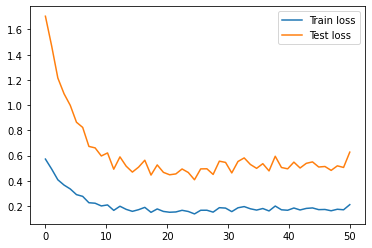

In [64]:
# loss curves
x = np.linspace(0,len(loss_tab), len(val_loss_tab))
plt.plot(x, loss_tab, label= "Train loss")
plt.plot(x, val_loss_tab, label = "Test loss")
plt.legend()

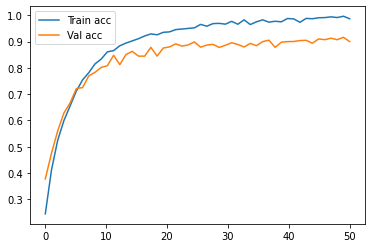

In [65]:
#Accuracy curves
x = np.linspace(0,len(acc_tab), len(val_acc_tab))
plt.plot(x, acc_tab, label= "Train acc")
plt.plot(x, val_acc_tab, label = "Val acc")
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0.5, 0, 'Predicted label')

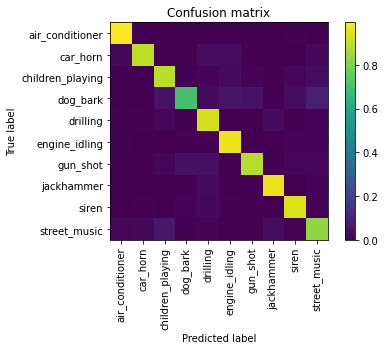

In [66]:
model.eval()
labels_tab =[]
pred_tab =[]
model_test = model.to("cpu")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels
        res = model_test(inputs)
        top_probs, top_class = torch.topk(torch.exp(res), 1,dim=1)
        labels_tab.append(labels.clone().detach().to("cpu"))
        pred_tab.append(top_class.clone().detach().to("cpu"))
        
classes = []
for values in range(0,10):
  classes.append(df[df[CLASSID] == values][CLASS].reset_index()[CLASS][0])

from sklearn.metrics import confusion_matrix
labels = np.concatenate([el.numpy() for el in labels_tab]).ravel()

pred = np.concatenate([el.numpy() for el in pred_tab]).ravel()

cm = confusion_matrix(labels, pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

fmt = '.2f' 
thresh = cm.max() / 2.

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Predict

In [67]:
i = int(np.random.random()*df.shape[0])
w = load_sound_by_index(i, df)
im = torch.mean(torch.sum(amp(torch.abs(torch.stft(w,799)[0])), axis=2).T, axis=0).reshape(20,20).numpy()
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((20,20)), transforms.Normalize(np.mean(arrOfImages),np.std(arrOfImages))])
im = torch.unsqueeze(transform(im),0)
res = model(im)
filepath = MOUNTING_LOCATION+PATH_TO_FOLDER+"fold"+str(df[FOLD][i])+os.path.sep+df[FILENAME][i]
prob, ind= torch.topk(torch.exp(res), 1,dim=1)
print(f"proba : {prob.item():.2f}")
print(f"Classe la plus probable {classes[ind]}")
ipd.Audio(filepath)

proba : 1.00
Classe la plus probable siren


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Observations 

This version using a smaller CNN on compressed spectrogram is really efficient, thanks to the smaller neural network used and it is possible to train it even faster than the larger one using resnet and pretrained weights.

The accuracy on test set is really good, as good as the larger version, but the loss on test set, seems to be a bit larger.
